In [171]:
import pandas as pd
import pandautils as pu
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ROOT
ROOT.gSystem.Load('./linkdef_C.so') # in root: .L linkdef.C+

1

In [3]:
input_vars = ['jet_pt', 'jet_eta', 'jet_phi', 'lep_pt', 'lep_eta', 'lep_phi', 'metx', 'mety', 'ME_Bkg_Likelihoods_Available',
             'ME_Sig_Likelihoods_Available', 'ME_Bkg_Mod_Likelihoods', 'ME_Sig_Mod_Likelihoods']

In [4]:
bkg_df = pu.root2panda('../samples/background.root', 
                       'Muon/6jetin252525252525_0elecex25topcommonetacommon_1muonex25topcommonetacommon/0btagin0.7892MV1/atree', 
                       branches = input_vars )

In [38]:
signal_df = pu.root2panda('../samples/signal.root', 
                          'Muon/6jetin252525252525_0elecex25topcommonetacommon_1muonex25topcommonetacommon/0btagin0.7892MV1/atree',
                         branches = input_vars)

# Get permutations using pyroot

In [6]:
background_file = ROOT.TFile('../samples/background.root')

In [28]:
signal_file = ROOT.TFile('../samples/signal.root')

In [7]:
bkgT = background_file.Get('Muon/6jetin252525252525_0elecex25topcommonetacommon_1muonex25topcommonetacommon/0btagin0.7892MV1/atree')

In [30]:
signalT = signal_file.Get('Muon/6jetin252525252525_0elecex25topcommonetacommon_1muonex25topcommonetacommon/0btagin0.7892MV1/atree')

In [8]:
bkg_perm = []
Nentries = bkgT.GetEntries()
for i in xrange(Nentries):
    bkgT.GetEntry(i)
    if i % 10000 == 0:
        print 'Event {} of {}'.format(i, Nentries)
    sp = []
    for j in xrange(bkgT.ME_Sig_Mod_Permutations[0][0].size()):
        sp.append(bkgT.ME_Sig_Mod_Permutations[0][0][j])
    bkg_perm.append(sp)

Event 0
Event 10000
Event 20000
Event 30000
Event 40000
Event 50000
Event 60000
Event 70000
Event 80000
Event 90000
Event 100000
Event 110000
Event 120000
Event 130000
Event 140000
Event 150000
Event 160000
Event 170000
Event 180000
Event 190000
Event 200000
Event 210000
Event 220000
Event 230000
Event 240000
Event 250000
Event 260000
Event 270000
Event 280000
Event 290000
Event 300000
Event 310000
Event 320000
Event 330000
Event 340000
Event 350000
Event 360000
Event 370000
Event 380000
Event 390000
Event 400000
Event 410000
Event 420000
Event 430000
Event 440000
Event 450000
Event 460000
Event 470000
Event 480000
Event 490000
Event 500000
Event 510000
Event 520000
Event 530000
Event 540000
Event 550000
Event 560000
Event 570000
Event 580000
Event 590000
Event 600000
Event 610000
Event 620000
Event 630000
Event 640000
Event 650000
Event 660000
Event 670000
Event 680000
Event 690000
Event 700000
Event 710000
Event 720000
Event 730000
Event 740000
Event 750000
Event 760000
Event 770000


In [31]:
signal_perm = []
Nentries = signalT.GetEntries()
for i in xrange(Nentries):
    signalT.GetEntry(i)
    if i % 10000 == 0:
        print 'Event {} of {}'.format(i, Nentries)
    sp = []
    for j in xrange(signalT.ME_Sig_Mod_Permutations[0][0].size()):
        sp.append(signalT.ME_Sig_Mod_Permutations[0][0][j])
    signal_perm.append(sp)

Event 0 of 113057
Event 10000 of 113057
Event 20000 of 113057
Event 30000 of 113057
Event 40000 of 113057
Event 50000 of 113057
Event 60000 of 113057
Event 70000 of 113057
Event 80000 of 113057
Event 90000 of 113057
Event 100000 of 113057
Event 110000 of 113057


In [40]:
bkg_df['jet_order'] = bkg_perm;
signal_df['jet_order'] = signal_perm;

In [64]:
bkg_df['metx/mety'] = bkg_df['metx']/bkg_df['mety'];
signal_df['metx/mety'] = signal_df['metx']/signal_df['mety'];

In [107]:
bkg_df['truth'] = 0;
signal_df['truth'] = 1;

In [108]:
# -- save to pickle, if you want
bkg_df.to_pickle('./bkg_df.pkl')
signal_df.to_pickle('./signal_df.pkl')
# there should be a better way of doing this using cPickle but I forget how to do it

# Event Processing

In [109]:
# "Ask for ME_Bkg_Likelihoods_Available[0] == true && ME_Sig_Likelihoods_Available[0] == true"
bkg_df1 = bkg_df[(bkg_df['ME_Bkg_Likelihoods_Available']==1) & (bkg_df['ME_Sig_Likelihoods_Available']==1)];
signal_df1 = signal_df[(signal_df['ME_Bkg_Likelihoods_Available']==1) & (signal_df['ME_Sig_Likelihoods_Available']==1)];

# Build X and y

In [208]:
tot_df = pd.concat([bkg_df1, signal_df1], ignore_index=True)

In [209]:
y = np.array(tot_df['truth'])

In [210]:
N_COL = 22 # number of features
X = np.zeros((bkg_df1.shape[0] + signal_df1.shape[0], N_COL))

In [ ]:
def pseudo(f, x):
    return np.sign(x) * f(np.abs(x))

In [211]:
X[:, 0] = tot_df['lep_pt'];
X[:, 0] = np.log(X[:, 0])
X[:, 1] = tot_df['lep_eta'];
X[:, 2] = tot_df['lep_phi'];
X[:, 3] = pseudo(np.log, tot_df['metx/mety']);
# X[:, 4] = pseudo(np.log, tot_df['metx']);
# X[:, 5] = pseudo(np.log, tot_df['mety']);

In [212]:
PT_COLUMN = 4
N_JETS = 6

ETA_COLUMN = PT_COLUMN + N_JETS
PHI_COLUMN = ETA_COLUMN + N_JETS
        
for event in xrange(tot_df.shape[0]):
    if event % 10000 == 0:
        print 'Event {} of {}'.format(event, tot_df.shape[0])
    reordering = np.array(tot_df['jet_order'][event][:-2]).astype('int') # -- -2 chops off the zero shit
    X[event, PT_COLUMN : (PT_COLUMN + N_JETS)] = np.log(tot_df['jet_pt'][event][reordering])
    X[event, ETA_COLUMN : (ETA_COLUMN + N_JETS)] = tot_df['jet_eta'][event][reordering]
    X[event, PHI_COLUMN : (PHI_COLUMN + N_JETS)] = tot_df['jet_phi'][event][reordering]

Event 0 of 1016336
Event 10000 of 1016336
Event 20000 of 1016336
Event 30000 of 1016336
Event 40000 of 1016336
Event 50000 of 1016336
Event 60000 of 1016336
Event 70000 of 1016336
Event 80000 of 1016336
Event 90000 of 1016336
Event 100000 of 1016336
Event 110000 of 1016336
Event 120000 of 1016336
Event 130000 of 1016336
Event 140000 of 1016336
Event 150000 of 1016336
Event 160000 of 1016336
Event 170000 of 1016336
Event 180000 of 1016336
Event 190000 of 1016336
Event 200000 of 1016336
Event 210000 of 1016336
Event 220000 of 1016336
Event 230000 of 1016336
Event 240000 of 1016336
Event 250000 of 1016336
Event 260000 of 1016336
Event 270000 of 1016336
Event 280000 of 1016336
Event 290000 of 1016336
Event 300000 of 1016336
Event 310000 of 1016336
Event 320000 of 1016336
Event 330000 of 1016336
Event 340000 of 1016336
Event 350000 of 1016336
Event 360000 of 1016336
Event 370000 of 1016336
Event 380000 of 1016336
Event 390000 of 1016336
Event 400000 of 1016336
Event 410000 of 1016336
Event 

In [213]:
# -- get number of available examples
ix = range(X.shape[0])
# -- shuffle the indices to shuffle X and y
np.random.shuffle(ix)
X, y = X[ix], y[ix]
# -- divide the sample in half for training and testing
n = int(0.6*X.shape[0] )

In [214]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Z = scaler.fit_transform(np.array(X))

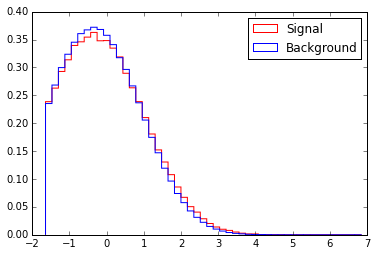

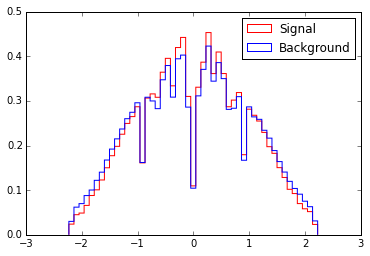

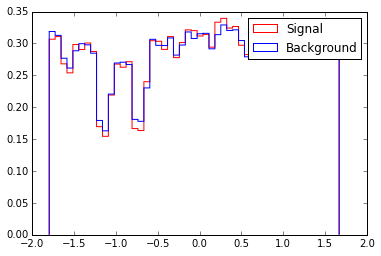

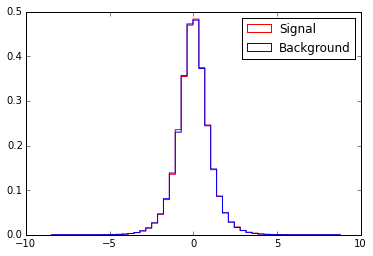

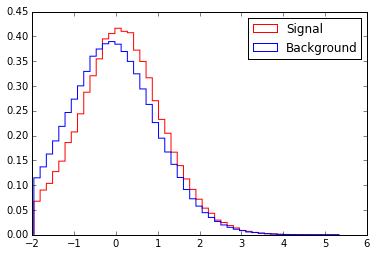

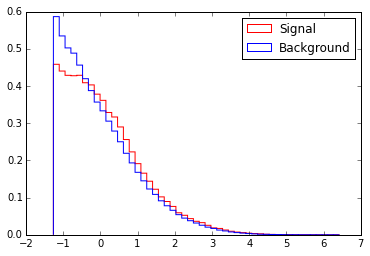

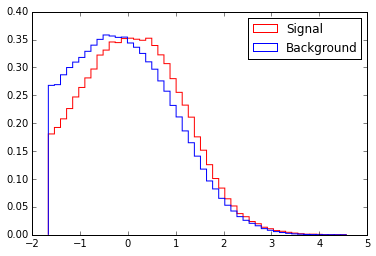

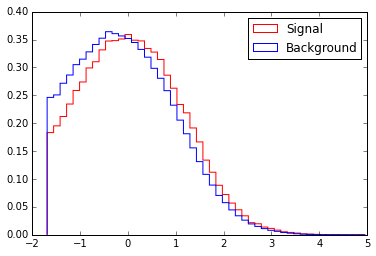

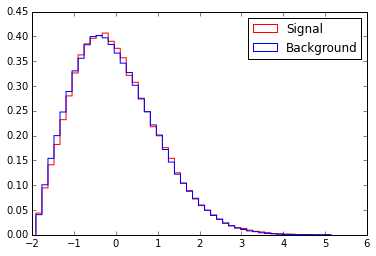

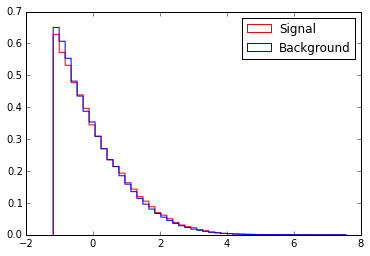

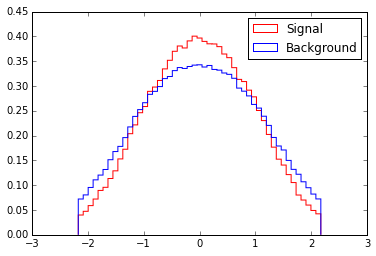

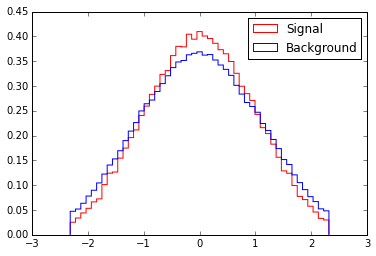

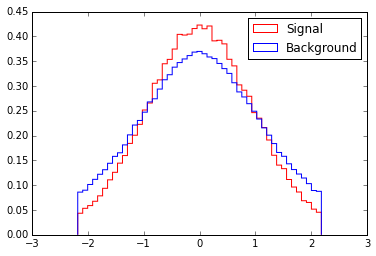

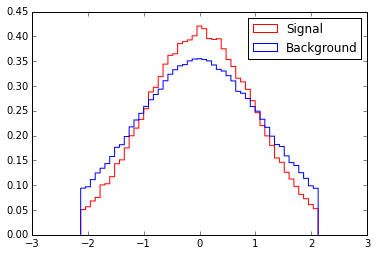

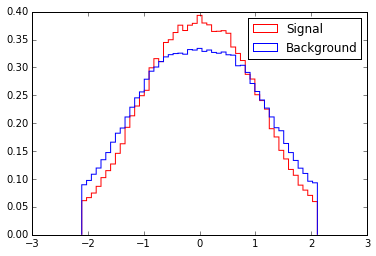

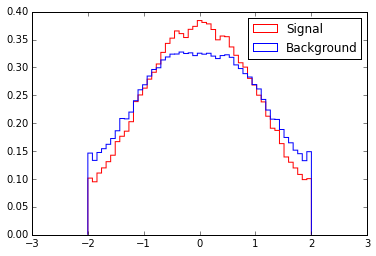

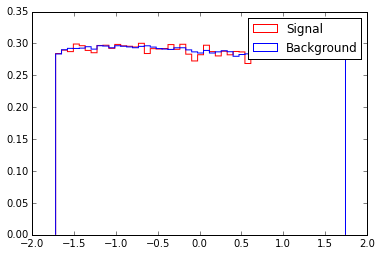

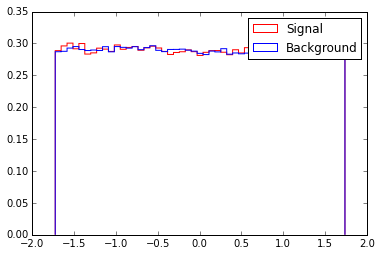

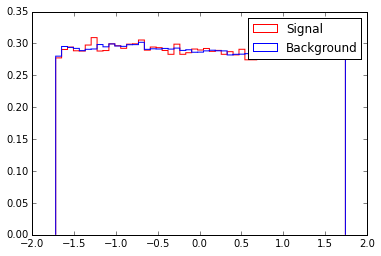

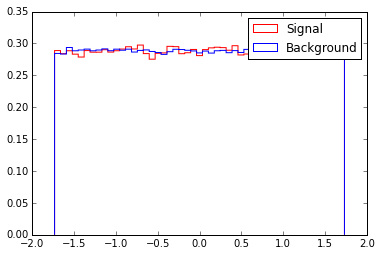

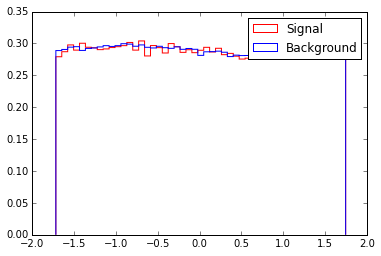

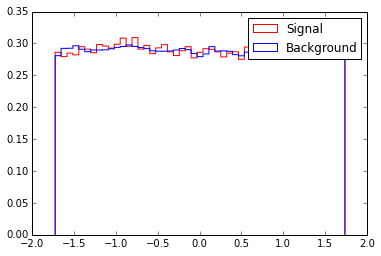

In [215]:
for col in Z.T:
    bins = np.linspace(col.min(), col.max(), 50)
    plt.hist(col[y==1], bins=bins,color = 'red', histtype='step', normed=True, label = 'Signal')
    plt.hist(col[y==0], bins=bins,color = 'blue', histtype='step', normed=True, label = 'Background')
    plt.legend()
    plt.show()

In [232]:
# Keras NN:
from keras.models import Sequential
from keras.layers.core import Dense, MaxoutDense, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint

net = Sequential()

net.add(MaxoutDense(64, 10, input_shape=(22, ), init='he_uniform'))
net.add(Dropout(0.6))

net.add(MaxoutDense(32, 10, init='he_uniform'))
net.add(Dropout(0.3))

net.add(Dense(32))#, init='he_uniform'))
net.add(Activation('relu'))
net.add(Dropout(0.2))

net.add(Dense(16))#, init='he_uniform'))
net.add(Activation('relu'))
net.add(Dropout(0.2))

net.add(Dense(8))#, init='he_uniform'))
net.add(Activation('relu'))
# net.add(Dropout(0.1))

net.add(Dense(1))#, init='he_uniform'))
net.add(Activation('sigmoid'))
#MD(64)-DO(0.6)-MD(32)-DO(0.3)-D(16)-relu-DO(0.2)-D(8)-relu-DO(0.1)-D(1)-sigmoid

net.compile('adam', 'binary_crossentropy', class_mode='binary')

In [234]:
weights = np.ones(Z.shape[0])
weights[y == 1] = 1 / (y.mean())

In [235]:
net.fit(Z[:n], y[:n], verbose=True, batch_size=128, show_accuracy=True, sample_weight=weights[:n], 
        callbacks = [
            EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
            ModelCheckpoint('mlmem_net.h5', 
                            monitor='val_loss', verbose=True, save_best_only=True)
        ],
        nb_epoch=70, validation_data=(Z[n:], y[n:], weights[n:]))

Train on 609801 samples, validate on 406535 samples
Epoch 1/70
609801/609801 [==============================] - 43s - loss: 0.6746 - acc: 0.4928 - val_loss: 0.6590 - val_acc: 0.5111
Epoch 00000: val_loss improved from inf to 0.65902, saving model to mlmem_net.h5
Epoch 2/70
609801/609801 [==============================] - 44s - loss: 0.6601 - acc: 0.5568 - val_loss: 0.6560 - val_acc: 0.5064
Epoch 00001: val_loss improved from 0.65902 to 0.65604, saving model to mlmem_net.h5
Epoch 3/70
609801/609801 [==============================] - 46s - loss: 0.6567 - acc: 0.5714 - val_loss: 0.6557 - val_acc: 0.5015
Epoch 00002: val_loss improved from 0.65604 to 0.65569, saving model to mlmem_net.h5
Epoch 4/70
609801/609801 [==============================] - 46s - loss: 0.6540 - acc: 0.5855 - val_loss: 0.6505 - val_acc: 0.5692
Epoch 00003: val_loss improved from 0.65569 to 0.65048, saving model to mlmem_net.h5
Epoch 5/70
609801/609801 [==============================] - 50s - loss: 0.6531 - acc: 0.5967

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [238]:
net.load_weights('./mlmem_net.h5')

In [284]:
yhat = net.predict(Z[n:], verbose=True)

406535/406535 [==============================] - 7s     


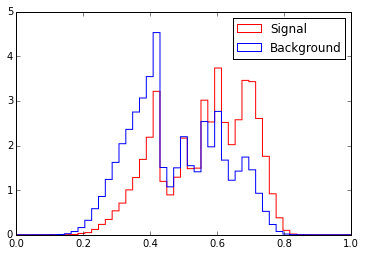

In [285]:
bins = np.linspace(0, 1, 50)
plt.hist(yhat[y[n:] == 1], bins=bins,color = 'red', histtype='step', normed=True, label = 'Signal')
plt.hist(yhat[y[n:] == 0], bins=bins,color = 'blue', histtype='step', normed=True, label = 'Background')
plt.legend()
plt.show()

# Matrix Element Method

In [243]:
soft_target = tot_df['ME_Sig_Mod_Likelihoods'] / (tot_df['ME_Sig_Mod_Likelihoods'] + 0.23 * tot_df['ME_Bkg_Mod_Likelihoods'])

In [245]:
soft_target = soft_target[ix]

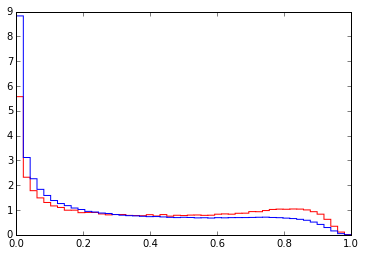

In [283]:
_ = plt.hist(pu.flatten(soft_target)[y == 1], color = 'red', histtype = 'step', bins = np.linspace(0,1,50), normed=True)
_ = plt.hist(pu.flatten(soft_target)[y == 0], color = 'blue', histtype = 'step', bins = np.linspace(0,1,50), normed=True)

In [258]:
%run viz/performance.py

In [281]:
n = int(n)
discs = {}
add_curve(r'MEM', 'black', calculate_roc(y, pu.flatten(soft_target), weights=weights), discs)
add_curve(r'Deep Network', 'red', calculate_roc(y[n:], yhat.ravel(), weights=weights[n:], bins=1000000), discs)

In [278]:
# y_pert = net.predict(Z[n:] + np.random.normal(0, 0.2, Z[n:].shape), verbose=True)

406535/406535 [==============================] - 7s     


In [279]:
# add_curve(r'Deep Network, perturbed', 'blue', calculate_roc(y[n:], y_pert.ravel(), weights=weights[n:], bins=1000000), discs)

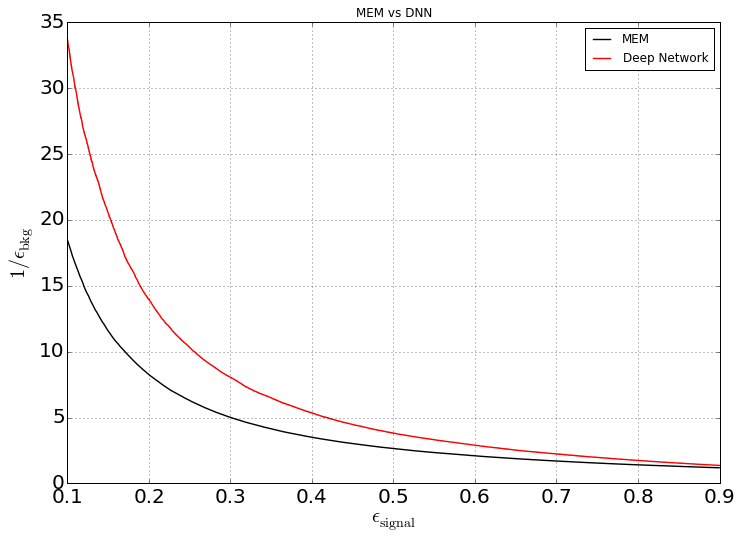

In [282]:
fg = ROC_plotter(discs, title=r'MEM vs DNN', min_eff = 0.1, max_eff=0.9, logscale=False)

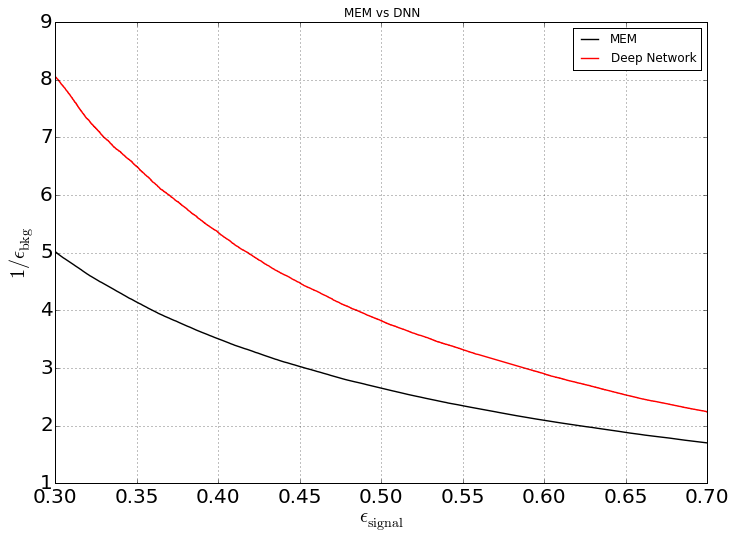

In [270]:
fg = ROC_plotter(discs, title=r'MEM vs DNN', min_eff = 0.3, max_eff=0.7, logscale=False)